In [1]:
# from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import numpy as np
from scipy import optimize
import os
import json
from matplotlib import pyplot as plt
import matplotlib

from collections import defaultdict

In [2]:
param_name_map = {
#         'policy_lr': 'trainer_kwargs/policy_lr',
#         'sep_subtask': 'env_config/env_kwargs/pretrain_assistance',
#         'awac': 'pretrain_steps',
    
        'qf_lr': 'trainer_kwargs/qf_lr',
        'sep_subtask': 'env_config/env_kwargs/pretrain_assistance',
        'bottleneck': 'trainer_kwargs/beta'
            }
param_value_map = {
#         'high_dim': {
#             ('high_dim','goal','reward'): 1,
#             ('goal','reward'): 0,
#             },
#         'hindopt': {-1: 'false', 10: 'true'},
        'window': {200: 1, 400: 2, 600: 3, 1000: 5, 2000: 10},
        'demo': {tuple([50]*100): 1, tuple([0]*100): 0}
#         'curriculum': {'target_session_curriculum': 1,'target_session': 0}
            }
param_names = list(param_name_map.keys())
results = {
#                 'eval_successes': 'evaluation/env_infos/final/task_success Mean',
#                 'eval_target1_reached': 'evaluation/env_infos/final/target1_reached Mean',
                'expl_completion': 'exploration/env_infos/final/tasks Mean',
                'eval_completion': 'evaluation/env_infos/final/tasks Mean',
                'expl_successes': 'exploration/env_infos/final/task_success Mean',
#                 'expl_target1_reached': 'exploration/env_infos/final/target1_reached Mean',

#                 'eval_noop': 'evaluation/env_infos/noop Mean',
    
#                 'eval_path_length': 'evaluation/path length Max',
    
#                 'qf_loss': 'trainer/QF Loss',
#                 'q_min': 'trainer/Q Predictions Min',
#                 'q_mean': 'trainer/Q Predictions Mean',
#                 'q_max': 'trainer/Q Predictions Max',
    
#                 'rewards_mean': 'trainer/R Predictions Mean',
#                 'train_noop_rate': 'trainer/Noop Rate',
#                 'rf_accuracy': 'trainer/RF Accuracy',
#                 'pred_logvar': 'trainer/Predicted Logvar',
#                 'pred_mean': 'trainer/Predicted Mean',
#                 'prior_logvar': 'trainer/Prior Logvar',
#                 'prior_mean': 'trainer/Prior Mean',
    
#                 'training_time': 'time/training (s)',
#                 'epoch_time': 'time/epoch (s)',
#                 'total_time': 'time/total (s)',
#                 'eval_time': 'time/evaluation sampling (s)',
            }
result_names = results.keys()
results = dict(zip(results.values(),results.keys()))
# tests = ['s1-stage2-3-keyboard-a','s1-stage2-3-keyboard','s1-stage2-3b']
# tests = ['as-stage2-keyboard-curr','as-stage2-keyboard-a','as-stage2-keyboard-a1','as-stage2-keyboard']
# tests = ['as-stage2-gaze-keyboard-1','as-stage2-gaze-keyboard']
# tests = ['as-stage2-gaze-keyboard-low-bc-gt-latent-act-wind']
# tests = ['s1-stage1-1c','s1-stage1-base']
# tests = ['b-stage1-6']
tests = ['k-stage1-10']

# tests = ['s1-stage2-calibrate']
test_params = ['s1_a','s1_b','s1_c','s1_d']
test_name = 'exploration'

In [3]:
!ls logs

as-baseline-end-to-end
as-s1-stage2-gaze-keyboard-low-bc-gt-latent
as-stage1-2
as-stage1-3
as-stage1-5
as-stage1-gt
as-stage2-gaze-keyboard
as-stage2-gaze-keyboard-1
as-stage2-gaze-keyboard-hold-out
as-stage2-gaze-keyboard-low-bc
as-stage2-gaze-keyboard-low-bc-gt-latent
as-stage2-gaze-keyboard-low-bc-gt-latent-1
as-stage2-gaze-keyboard-low-bc-gt-latent-2
as-stage2-gaze-keyboard-low-bc-gt-latent-2a
as-stage2-gaze-keyboard-low-bc-gt-latent-act-wind
as-stage2-gaze-keyboard-low-bc-gt-latent-block
as-stage2-gaze-keyboard-low-bc-gt-latent-mix-belief
as-stage2-gaze-keyboard-low-bc-gt-latent-mix-belief-act-wind
as-stage2-gaze-keyboard-low-bc-gt-latent-new-expl
as-stage2-gaze-keyboard-no-expl
as-stage2-gaze-keyboard-on-off
as-stage2-gaze-keyboard-on-off-1
b-stage1-2
b-stage1-2a
b-stage1-3
b-stage1-4
b-stage1-6
b-stage1-7
b-stage2-calibrate-slide
b-stage2-calibrate-slide-1
b-stage2-vanilla
implicit_reward
k-stage1-1
k-stage1-10
k-stage1-2
k-stage1-3
k-stage1-4
k-stage1-5
k-stage1-6
k-stage1-7
k-

In [4]:
!ls logs/b-stage1-2

b-stage1-2_2021_05_28_18_44_43_0000--s-0
b-stage1-2_2021_05_28_18_44_43_0001--s-0
b-stage1-2_2021_05_28_18_44_43_0002--s-0
b-stage1-2_2021_05_28_18_44_44_0003--s-0


In [5]:
paths = sum([[(os.path.join(path,run),test) for run in os.listdir(path)] 
             for path,test in [(os.path.join(os.path.abspath(''),'logs',test,),test) for test in tests]],[])    
# import ray
# ray.init(_temp_dir='/tmp/ray_exp',)
# @ray.remote(num_cpus=1,num_gpus=0)
# class Reader:
#     def read(self,paths):
def read(paths):
    dfs = []
    for path,test in paths:
#             try:
            df = pd.read_csv(os.path.join(path,'progress.csv'),usecols=results.keys()) 
#             df = pd.read_csv(os.path.join(path,'progress.csv')) 
#             print(list(df.columns))
            params = []
            with open(os.path.join(path,'variant.json'),) as f:
                all_params = json.load(f) 
            for name in param_names:
                param = all_params
                for key in param_name_map[name].split('/'):
#                         print(param)
                    param = param.get(key,0)
                    if param == None:
                        param = -1
                if isinstance(param,list):
                    param = tuple(param)
                if name in param_value_map:
                    param = param_value_map[name][param]
                params.append(param)

            test_map = dict(zip(tests, test_params))
            df.columns = pd.MultiIndex.from_tuples([tuple(params+[test_map[test],results[result]]) for result in df.columns])

            dfs.append(df)
#             except:
#                 continue
    return dfs
    
# num_workers = 1
# readers = [Reader.remote() for i in range(num_workers)]
# dfs = [reader.read.remote(path_sect) for reader,path_sect in zip(readers,np.array_split(paths,num_workers))]
# dfs = [ray.get(read) for read in dfs]
# ray.shutdown()
dfs = read(paths)
# dfs = sum(dfs,[])

In [6]:
# ray.shutdown()

In [7]:
df = pd.concat(dfs,axis='columns',ignore_index=True)
df.columns = pd.MultiIndex.from_frame(pd.concat([df.columns.to_frame(index=False) for df in dfs],ignore_index=True))
# print(df.columns)
df.columns.names = param_names+[test_name,'results']
param_names1 = param_names.copy()
# param_names1.remove('seedid')
# param_names1.remove('reward_bias')
# print(dfs[0][:,idx[[(15000,)], [2000], [True], [0.5], ['after'], ['eval_successes']]])
df_std = df.groupby(axis='columns',level=param_names1+[test_name,'results']).std()
df_mean = df = df.groupby(axis='columns',level=param_names1+[test_name,'results']).mean()

# df.columns.names = param_names+['seedid',test_name,'results']
# df_std = df.groupby(axis='columns',level=param_names+['seedid',test_name,'results']).std()
# df_mean = df = df.groupby(axis='columns',level=param_names+['seedid',test_name,'results']).mean()

In [8]:
for name in df.columns.names:
    print(f"{name}: {df.columns.get_level_values(name).unique().tolist()}")
for df_i in dfs:
    print(df_i.shape,df_i.columns[0])

qf_lr: [0.0003, 0.001]
sep_subtask: [False, True]
bottleneck: [0.01, 0.1]
exploration: ['s1_a']
results: ['eval_completion', 'expl_completion', 'expl_successes']
(28, 3) (0.001, False, 0.1, 's1_a', 'eval_completion')
(28, 3) (0.0003, True, 0.01, 's1_a', 'eval_completion')
(28, 3) (0.0003, False, 0.1, 's1_a', 'eval_completion')
(28, 3) (0.0003, True, 0.1, 's1_a', 'eval_completion')
(28, 3) (0.001, True, 0.1, 's1_a', 'eval_completion')
(28, 3) (0.001, True, 0.01, 's1_a', 'eval_completion')
(29, 3) (0.001, False, 0.01, 's1_a', 'eval_completion')
(28, 3) (0.0003, False, 0.01, 's1_a', 'eval_completion')


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


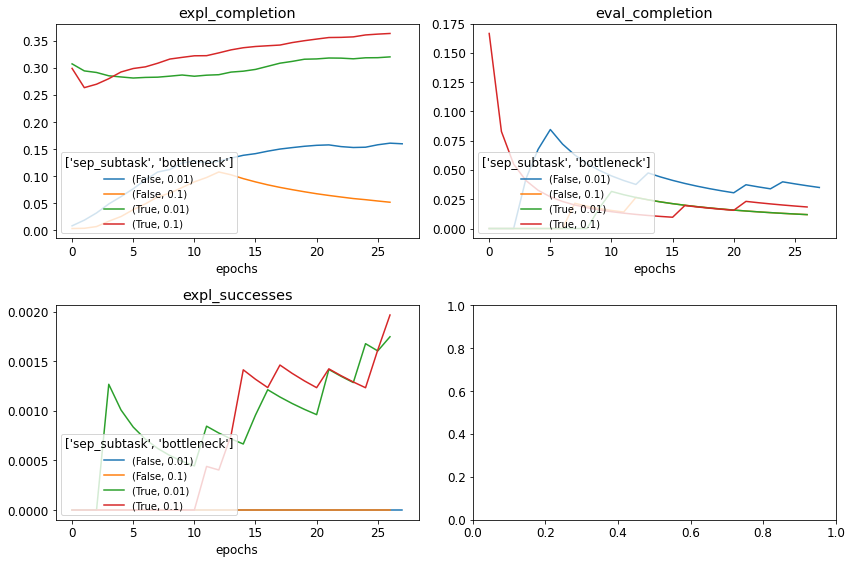

In [9]:
alphas = dict(zip(result_names,[.01]*len(result_names)))
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
# fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
fig, axs = plt.subplots(nrows=(len(result_names)+1)//2,ncols=2,figsize=(12,4*(len(result_names)+1)//2))
axs = axs.flatten()
idx = pd.IndexSlice

t = int(10000)
for (name,alpha),ax in zip(alphas.items(),axs):
#     try:
#         idx_slice = idx[:,[500],:,name]
        idx_slice = idx[[1e-3],:,:,:,name]

#         idx_slice = idx[['AnySwitch'],[20000],[0],:,:,name]
        mean_graph = df.loc[:,idx_slice]
        std_graph = df_std.loc[:,idx_slice]
        
#         relabel_ind = mean_graph.columns.get_level_values('window')
#         for i in relabel_ind:
#             modded_relabel = mean_graph.iloc[:,relabel_ind==i]\
#                     .loc[mean_graph.index.repeat(i)].reset_index(drop=True)
#             for col in modded_relabel:
#                 mean_graph[col] = modded_relabel[col]

        mean_graph.columns = mean_graph.columns.droplevel(
            [c for c in mean_graph.columns.names
               if mean_graph.columns.get_level_values(c).unique().size == 1]\
#             +['window']
        )        
        std_graph.columns = std_graph.columns.droplevel(
            [c for c in mean_graph.columns.names
               if mean_graph.columns.get_level_values(c).unique().size == 1]\
#             +['terminal_regular_prop']

        )
        std_graph = std_graph.ewm(alpha=alpha).mean()
#         std_graph = std_graph.rolling(10).mean().loc[:t]
#         std_graph = std_graph.rolling(100).mean().loc[:t]
#         mean_graph = mean_graph.ewm(alpha=alpha).mean()
#         mean_graph = mean_graph.rolling(10).mean().loc[:t]
#         mean_graph = mean_graph.rolling(100).mean().loc[:t]
    
        strings = ['random-ordering','relabelling','curriculum','curriculum+relabel']
#         for i,((col_names,mean),(_col_names,std)) in enumerate(zip(mean_graph.iteritems(),std_graph.iteritems())):

        for i,col_names in enumerate(mean_graph):
            mean = mean_graph[col_names]
            mean = mean[:min(mean.last_valid_index(),t)].ewm(alpha=alpha).mean()
#            ax.fill_between(x=range(mean.size),y1=np.maximum(0,mean-std),y2=np.minimum(1,mean+std),alpha=.3)
#             ax.fill_between(x=range(mean.size),y1=mean-std,y2=mean+std,alpha=.3)
#             ax.plot(range(mean.size),mean,label=strings[i])
            ax.plot(range(mean.size),mean,label=col_names)
#             if i in [0,2,5,6]:
#                 break
#                 ax.plot(range(mean.size),mean,label=strings[i])
        
#         if name in default_policy.keys():
#             for policy,value in default_policy[name].items():
#                 ax.plot(range(t),[value]*t,label=policy)


        ax.set_title(name)
#         ax.set_title('BottleMaze Evaluation Success')
        ax.legend(loc=3,fontsize='small',title=mean_graph.columns.names)
#         ax.legend(loc=3,fontsize='small')
#         ax.legend(loc=3,fontsize='x-small',title='(method, grad steps)')

        ax.set_xlabel('epochs')
#         ax.set_xlabel('episodes')

fig.tight_layout()
#     except:
#         continue
# plt.title('LightSwitch Reproduce Result')

In [15]:
paths = [
         np.load(os.path.join(os.path.abspath(''),'demos',demo+".npy"),allow_pickle=True)
        for demo in ["Bottle_model_off_policy_10000_p_.7_eps_.5_1","Bottle_model_off_policy_10000_p_.6_eps_.5_1",]
#         for demo in ["OneSwitch_model_off_policy_10000_all_1",]
]
#          for demo in os.listdir(os.path.join(os.path.abspath(''),'demos')) if "OneSwitch_model_on_policy_10000_all_1" in demo
# ]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/00schen/share/miniconda3/envs/sparse/lib/python3.7/site-packages/numpy/lib/format.py", line 744, in read_array
    array = pickle.load(fp, **pickle_kwargs)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/00schen/share/miniconda3/envs/sparse/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-97e8cdeddc72>", line 3, in <module>
    for demo in ["Bottle_model_off_policy_10000_p_.7_eps_.5_1","Bottle_model_off_policy_10000_p_.6_eps_.5_1",]
  File "<ipython-input-15-97e8cdeddc72>", line 3, in <listcomp>
    for demo in ["Bottle_model_off_policy_10000_p_.7_eps_.5_1","Bottle_model_off_policy_10000_p_.6_eps_.5_1",]
  File "/home/00schen/share/miniconda3/envs/sparse/lib/python3.7/site-packages/numpy/lib/npyio.py", line 453, in load
    pickle_kwar

TypeError: object of type 'NoneType' has no len()

In [9]:
path_names = ['noisy_demo', 'very_noise_demo']
info_result_name = ['eval_successes','eval_noop','eval_path_length']
make_policy_values = lambda retriever,policy_names,policy_paths:\
    {name: retriever(paths) for name, paths in zip(policy_names,policy_paths)}
default_policy = {
    'eval_successes': make_policy_values(lambda paths: np.mean([path['env_infos'][-1]['task_success'] for path in paths]),
                                        path_names,paths),
    'eval_noop': make_policy_values(lambda paths: np.mean(sum([[info['noop'] for info in path['env_infos']] for path in paths],[])),
                                        path_names,paths),
    'eval_path_length': make_policy_values(lambda paths: np.mean([len(path['rewards']) for path in paths]),
                                        path_names,paths),
           }

In [ ]:
alphas = dict(zip(result_names,[.01]*len(result_names)))
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(nrows=(len(result_names)+1)//2,ncols=2,figsize=(15,5))
axs = axs.flatten()
idx = pd.IndexSlice
test_name_map = {'experiment2-laptop-dqn':'dqn','experiment2-laptop-sac':'sac',
                 'experiment2-laptop-dqn-cql':'cql-dqn','experiment2-laptop-cql':'cql-sac',}
metric_name_map = {'expl_successes':'Success Rate','expl_noop': 'User Noop Rate'}

# slice_df = slice_df.drop(columns=[(5e-4,1e-2),(1e-3,1e-2)])
# print(slice_df.head())


for (name,alpha),ax in zip(alphas.items(),axs):
#     try:
        mean_graph = df_mean.loc[:,idx[:,:,:,:,name]]
        std_graph = df_std.loc[:,idx[:,:,name]]
#         graph_df = df.loc[:,[(.001,.1,.1,name),(.001,1,.3,name)]]

#         graph_df = graph_df.drop(columns=[(1e-3,5e-5,1e-2)])
        mean_graph.columns = mean_graph.columns.droplevel([c for c in mean_graph.columns.names
                                                           if mean_graph.columns.get_level_values(c).unique().size == 1])
        mean_graph = mean_graph.ewm(alpha=alpha).mean()
        std_graph.columns = std_graph.columns.droplevel([c for c in std_graph.columns.names
                                                         if std_graph.columns.get_level_values(c).unique().size == 1])
        std_graph = std_graph.ewm(alpha=alpha).mean()
        for (col_names,mean),(_col_names,std) in zip(mean_graph.iteritems(),std_graph.iteritems()):
            ax.fill_between(x=range(mean.size),y1=np.maximum(0,mean-std),y2=np.minimum(1,mean+std),alpha=.3)
            ax.plot(range(mean.size),mean,label=f"({not col_names[0]},{test_name_map[col_names[1]]})")
        ax.set_title(metric_name_map[name])
        ax.set_xlabel("Epochs")
#         ax.legend(loc=3,fontsize='xx-small',title_fontsize='xx-small',title="user input penalty,algorithm")
        ax.legend(loc=3,fontsize='xx-small',title_fontsize='xx-small',title="user input penalty,algorithm")
#     except:
#         continue

# plt.savefig('experiment2_laptop_full.png')

In [50]:
success

{'thr_.5_eps_50': 1.0,
 'thr_.5_eps_25': 1.0,
 '_thr_.5_eps_0': 1.0,
 '_thr_.0_eps_0': 1.0,
 '_thr_.2_eps_0': 0.99375}

In [51]:
noop

{'thr_.5_eps_50': 0.5710240436595788,
 'thr_.5_eps_25': 0.6327110825018775,
 '_thr_.5_eps_0': 0.6814617849594328,
 '_thr_.0_eps_0': 0.7638537347191556,
 '_thr_.2_eps_0': 0.7429401323220913}

In [22]:
params_2_test = defaultdict(list)

for path in paths:
    test_name = os.path.split(os.path.split(path)[0])[1]     

    params = []
    with open(os.path.join(path,'variant.json'),) as f:
        all_params = json.load(f) 
    for name,full_name in zip(param_names,param_full_names):
        param = all_params
        for key in full_name.split('/'):
            param = param.get(key,0)
        params.append(param)
    params = tuple(params)
    params_2_test[params].append(test_name)
    

TypeError: expected str, bytes or os.PathLike object, not tuple

In [32]:
params_2_test

defaultdict(list,
            {(1000,): ['run1', 'run0', 'run4'],
             (1,): ['run5', 'run2', 'run3']})

In [67]:
trajs = [np.load(os.path.join(os.path.abspath(''),'eval_paths1',f"{run[3:]}_eval_paths.npy"),allow_pickle=True)
             for run in ['run14']]

In [68]:
print(len(trajs[0]))

18


In [85]:
pos = sum([[tr['observations'][:,-20:-17] for tr in traj[:40]] for traj in trajs],[])
pos1 = pos[0]
mean_pos = np.mean(pos1,axis=0)
max_extent = np.max(np.linalg.norm(pos1-mean_pos,axis=1))
pos1 = (pos1-mean_pos)/max_extent

pos2 = pos[1]
mean_pos = np.mean(pos2,axis=0)
max_extent = np.max(np.linalg.norm(pos2-mean_pos,axis=1))
pos2 = (pos2-mean_pos)/max_extent

# pos = np.mean(pos,axis=0)
reg_pos = []
for traj in pos:
    mean_pos = np.mean(traj,axis=0)
    max_extent = np.max(np.linalg.norm(traj-mean_pos,axis=1))
    traj = (traj-mean_pos)/max_extent
    reg_pos.append(traj)
pos = np.array([np.mean([sample[i] for sample in reg_pos if len(sample) > i],axis=0) for i in range(200)])


NameError: name 'trajs' is not defined

In [70]:
# a = .15
# b = .3
# c = .6

In [71]:
dpos = [tr['observations'][:,-20:-17] for tr in defaults[0]]
dpos1 = dpos[0]
mean_pos = np.mean(dpos1,axis=0)
max_extent = np.max(np.linalg.norm(dpos1-mean_pos,axis=1))
dpos1 = (dpos1-mean_pos)/max_extent

dreg_pos = []
for traj in dpos:
    mean_pos = np.mean(traj,axis=0)
    max_extent = np.max(np.linalg.norm(traj-mean_pos,axis=1))
    traj = (traj-mean_pos)/max_extent
    dreg_pos.append(traj)
dpos = np.array([np.mean([sample[i] for sample in dreg_pos if len(sample) > i],axis=0) for i in range(200)])


In [72]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

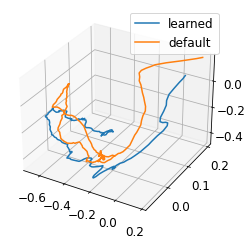

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*list(zip(*pos)),label='learned')
ax.plot(*list(zip(*dpos)),label='default')
ax.legend()

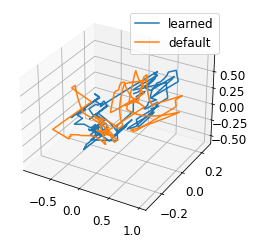

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*list(zip(*pos1)),label='learned')
ax.plot(*list(zip(*dpos1)),label='default')
ax.legend()

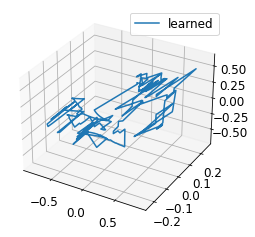

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*list(zip(*pos2)),label='learned')
# ax.plot(*list(zip(*dpos2)),label='default')
ax.legend()